In [206]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr, spearmanr
plt.style.use('../images/presentation.mplstyle')
plt.rcParams["figure.figsize"] = (12, 6)
import scipy as sc
import seaborn as sns

In [2]:
def get_cmap(n=20, map_str= 'hsv'):
    cmap = plt.get_cmap(map_str)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [116]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
geo_stats = pd.read_csv("geographic-sum-per-day-ver_00141.csv")
# geo_stats_2 = pd.read_csv("corona_city_table_ver_0076.csv")
# geo_vacc_per_age = pd.read_csv("vaccinated_city_table_ver_0031.csv")


# recover_data = pd.read_excel("corona_recovered_ver_00120.xlsx")
# hospital_data = pd.read_csv("corona_hospitalization_ver_00231.csv")
# dead_data = pd.read_csv("corona_deceased_ver_0095.csv")

# age_gender_test_data = pd.read_csv("corona_age_and_gender_ver_0092.csv")
# young_test_data = pd.read_excel("young_population_weekly_ver_0037.xlsx")

In [4]:
israel_population = pd.read_excel("israel_population_by_city.xlsx")
israel_population_with_ages = pd.read_excel("israel_total_population_by_age.xlsx")
israel_english_names = pd.read_excel("israel_town_code_name_english.xlsx")
median_israeli_population = pd.read_excel("median_israeli_population.xlsx")

## organize geographic data 

In [5]:
geo_stats = pd.read_csv("geographic-sum-per-day-ver_00141.csv")
geo_stats['date'] = pd.to_datetime(geo_stats['date'],format='%Y-%m-%d')

In [12]:
geo_stats['weeks_from'] = np.round((geo_stats['date'] - pd.to_datetime('2020-03-21',format='%Y-%m-%d')).dt.days / 7, 1).astype(int)
geo_stats = geo_stats[geo_stats.weeks_from >= 0]

In [13]:
geo_stats = geo_stats.replace(to_replace={'<15': 4})

In [14]:
geo_float_columns = ['accumulated_cases',
       'new_cases_on_date', 'accumulated_recoveries', 'new_recoveries_on_date',
       'accumulated_hospitalized', 'new_hospitalized_on_date',
       'accumulated_deaths', 'new_deaths_on_date',
       'accumulated_diagnostic_tests', 'new_diagnostic_tests_on_date',
       'accumulated_vaccination_first_dose', 'new_vacc_first_dose_on_date',
       'accumulated_vaccination_second_dose', 'new_vacc_second_dose_on_date']
geo_stats[geo_float_columns] = geo_stats[geo_float_columns].astype(float)

In [15]:
weeks_dict_agas = {'weeks_from': 'first',
                   'town_code': 'first',
              'town': 'first', 
              'date': 'first', 
              'accumulated_cases': 'sum',
              'new_cases_on_date': 'sum', 
              'accumulated_recoveries': 'sum', 
              'new_recoveries_on_date': 'sum',
              'accumulated_hospitalized': 'sum', 
              'new_hospitalized_on_date': 'sum',
              'accumulated_deaths': 'sum',
              'new_deaths_on_date': 'sum',
              'accumulated_diagnostic_tests': 'sum',
              'new_diagnostic_tests_on_date': 'sum',
              'accumulated_vaccination_first_dose':'sum',
              'new_vacc_first_dose_on_date': 'sum',
              'accumulated_vaccination_second_dose': 'sum',
              'new_vacc_second_dose_on_date': 'sum'}
weeks_dict = {
              'town_code': 'first',
              'town': 'first', 
              'date': 'last', 
              'accumulated_cases': 'last',
              'new_cases_on_date': 'sum', 
              'accumulated_recoveries': 'last', 
              'new_recoveries_on_date': 'sum',
              'accumulated_hospitalized': 'last', 
              'new_hospitalized_on_date': 'sum',
              'accumulated_deaths': 'last',
              'new_deaths_on_date': 'sum',
              'accumulated_diagnostic_tests': 'last',
              'new_diagnostic_tests_on_date': 'sum',
              'accumulated_vaccination_first_dose':'last',
              'new_vacc_first_dose_on_date': 'sum',
              'accumulated_vaccination_second_dose': 'last',
              'new_vacc_second_dose_on_date': 'sum'}
geo_stats = geo_stats.groupby(['town_code', 'date'], as_index=False).agg(weeks_dict_agas)
geo_stats = geo_stats.groupby(['weeks_from', 'town_code'], as_index=False).agg(weeks_dict)

In [16]:
israel_english_names = israel_english_names.rename(columns={'town':'city'})

In [17]:
israel_population = israel_population.rename(columns={'city_code':'town_code', 'city': 'town'})

In [18]:
median_israeli_population = median_israeli_population.rename(columns={'city_code':'town_code'})

In [19]:
median_israeli_population = median_israeli_population.drop(columns=['city', 'population_size','city_english'])

In [20]:
geo_stats = pd.merge(median_israeli_population, geo_stats, how='right', on='town_code')

In [21]:
geo_stats = pd.merge(israel_population, geo_stats, how='right', on=['town_code'])

In [22]:
geo_stats = pd.merge(israel_english_names, geo_stats, how='right', on='town_code')

In [23]:
percentage_dict = {f'percentage_{w}' : 100 * geo_stats[w] / geo_stats['num_population'] for w in geo_float_columns}
percentage_dict['weeks_from'] = geo_stats.weeks_from
percentage_dict['town_code'] = geo_stats.town_code
percentage_df = pd.DataFrame(percentage_dict)

In [24]:
geo_stats = pd.merge(geo_stats, percentage_df, on=['weeks_from', 'town_code'], how='inner')

In [25]:
geo_stats['percentage_accumulated_immuned'] = geo_stats.percentage_accumulated_recoveries + geo_stats.percentage_accumulated_vaccination_second_dose
geo_stats['accumulated_immuned'] = geo_stats.accumulated_recoveries + geo_stats.accumulated_vaccination_second_dose

In [26]:
# geo_stats_48 = geo_stats[geo_stats['weeks_from'] == 48]
# geo_stats_50_52 = geo_stats[(geos_stats['weeks_from']>=50) & (geos_stats['weeks_from']<53)]
# total_country_per_week = geo_stats.groupby('weeks_from').agg(weeks_dict)
total_weeks_dict = {'date': 'last', 
              'accumulated_cases': 'sum',
              'new_cases_on_date': 'sum', 
              'accumulated_recoveries': 'sum', 
              'new_recoveries_on_date': 'sum',
              'accumulated_hospitalized': 'sum', 
              'new_hospitalized_on_date': 'sum',
              'accumulated_deaths': 'sum',
              'new_deaths_on_date': 'sum',
              'accumulated_diagnostic_tests': 'sum',
              'new_diagnostic_tests_on_date': 'sum',
              'accumulated_vaccination_first_dose':'sum',
              'new_vacc_first_dose_on_date': 'sum',
              'accumulated_vaccination_second_dose': 'sum',
              'new_vacc_second_dose_on_date': 'sum', 
              'accumulated_immuned': 'sum'}
total_country_per_week = geo_stats.groupby('weeks_from', as_index=False).agg(total_weeks_dict)[['weeks_from', 'new_cases_on_date']].rename(columns={'new_cases_on_date':'new_cases_on_date_country'})
total_immune_country_per_week = geo_stats.groupby('weeks_from', as_index=False).agg(total_weeks_dict)[['weeks_from', 'accumulated_immuned']].rename(columns={'accumulated_immuned':'accumulated_immuned_country'})
geo_stats = pd.merge(total_country_per_week, geo_stats, how='right', on='weeks_from')
geo_stats = pd.merge(total_immune_country_per_week, geo_stats, how='right', on='weeks_from')

In [27]:
geo_stats['percentage_new_cases_on_date_country'] = 100 * geo_stats['new_cases_on_date_country'] / 9200000
geo_stats['percentage_accumulated_immuned_country'] = 100 * geo_stats['accumulated_immuned_country'] / 9200000

In [28]:
geo_stats['percentage_new_cases_on_date_by_tot'] = 100 * (geo_stats['new_cases_on_date'] / geo_stats['new_cases_on_date_country'])

In [29]:
geo_stats.columns

Index(['weeks_from', 'accumulated_immuned_country',
       'new_cases_on_date_country', 'town_code', 'city', 'town_english',
       'city_name', 'num_population', 'median_age', 'town', 'date',
       'accumulated_cases', 'new_cases_on_date', 'accumulated_recoveries',
       'new_recoveries_on_date', 'accumulated_hospitalized',
       'new_hospitalized_on_date', 'accumulated_deaths', 'new_deaths_on_date',
       'accumulated_diagnostic_tests', 'new_diagnostic_tests_on_date',
       'accumulated_vaccination_first_dose', 'new_vacc_first_dose_on_date',
       'accumulated_vaccination_second_dose', 'new_vacc_second_dose_on_date',
       'percentage_accumulated_cases', 'percentage_new_cases_on_date',
       'percentage_accumulated_recoveries',
       'percentage_new_recoveries_on_date',
       'percentage_accumulated_hospitalized',
       'percentage_new_hospitalized_on_date', 'percentage_accumulated_deaths',
       'percentage_new_deaths_on_date',
       'percentage_accumulated_diagnostic_t

In [31]:
# geo_stats.sort_values(ascending=False, by='num_population').num_population.unique()
geo_stats_big_cities = geo_stats[(geo_stats.num_population >= 1000)]
geo_stats_big_cities_40 = geo_stats_big_cities[(geo_stats_big_cities.weeks_from >= 40) & ((geo_stats.weeks_from < np.max(geo_stats.weeks_from)))]
geo_stats_40 = geo_stats[(geo_stats.weeks_from >= 40) & ((geo_stats.weeks_from < np.max(geo_stats.weeks_from)))]

[]

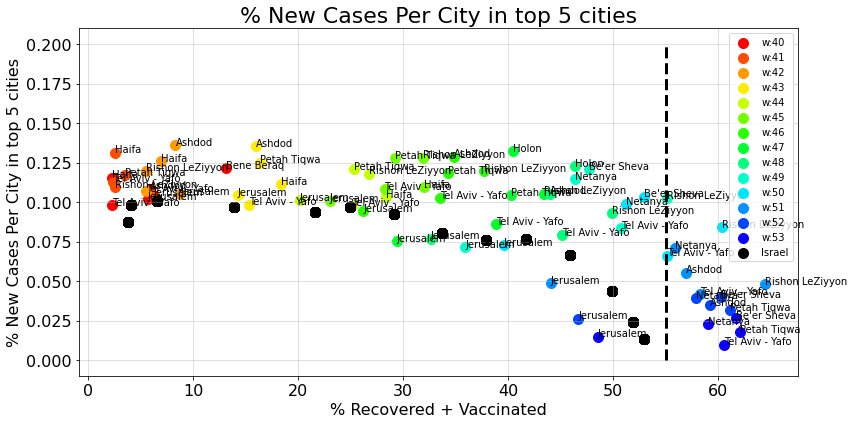

In [32]:
fig, ax = plt.subplots(1, 1)
pearson_coeff = []
spearman_coeff = []
colors = get_cmap(20)
num_cities = 5
for i, (w, df_w) in enumerate(geo_stats_40.groupby('weeks_from')):
    df_w = df_w.sort_values(ascending=False, by='new_cases_on_date')
    df_w = df_w.iloc[:num_cities,:]
    percentage_accumulated_r = df_w['percentage_accumulated_vaccination_second_dose'] + df_w['percentage_accumulated_recoveries']
#     percentage_new_cases = 100 * (df_w['new_cases_on_date'] / df_w['new_cases_on_date_country'])
#     percentage_new_cases =  df_w['percentage_new_cases_on_date'] #- df_w['percentage_new_cases_on_date_country'])
    percentage_new_cases =  df_w['percentage_new_cases_on_date'] 
    df_w['percentage_new_cases'] = percentage_new_cases
    ax.scatter(percentage_accumulated_r, percentage_new_cases, label=f'w:{w}', color=colors[i])
    p_coeff, _ = pearsonr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
    s_coeff, _ = spearmanr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
    pearson_coeff.append(p_coeff)
    spearman_coeff.append(s_coeff)
    for x, y, c in zip(percentage_accumulated_r, percentage_new_cases, df_w['town_english']):
        plt.text(x, y, c)
ax.scatter(geo_stats_40.percentage_accumulated_immuned_country, geo_stats_40.percentage_new_cases_on_date_country, c='k', label='Israel')
ax.set_xlabel('% Recovered + Vaccinated')
ax.set_title(f'% New Cases Per City in top {num_cities} cities')
ax.set_ylabel(f'% New Cases Per City in top {num_cities} cities')
ax.legend()
ax.grid()
ax.plot([55, 55], [0, 0.2], linestyle='--', linewidth=3, color='k')
ax.plot()

[]

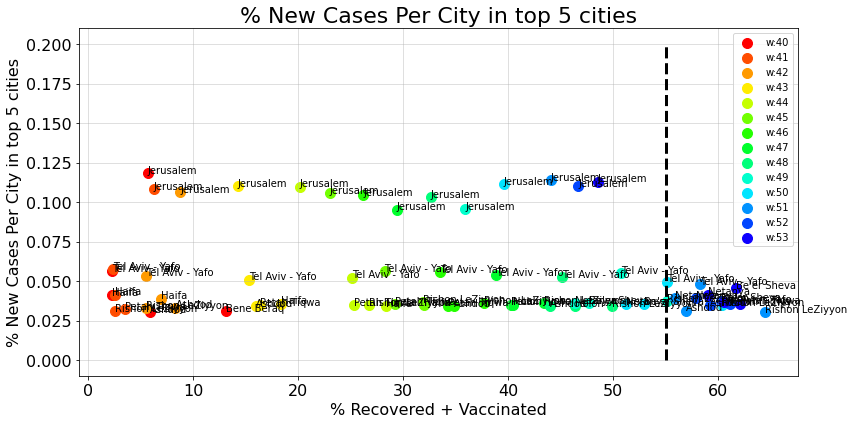

In [36]:
fig, ax = plt.subplots(1, 1)
pearson_coeff = []
spearman_coeff = []
colors = get_cmap(20)
num_cities = 5
for i, (w, df_w) in enumerate(geo_stats_40.groupby('weeks_from')):
    df_w = df_w.sort_values(ascending=False, by='new_cases_on_date')
    df_w = df_w.iloc[:num_cities,:]
    percentage_accumulated_r = df_w['percentage_accumulated_vaccination_second_dose'] + df_w['percentage_accumulated_recoveries']
#     percentage_new_cases = 100 * (df_w['new_cases_on_date'] / df_w['new_cases_on_date_country'])
#     percentage_new_cases =  df_w['percentage_new_cases_on_date'] #- df_w['percentage_new_cases_on_date_country'])
    percentage_new_cases =  df_w['new_cases_on_date'] / df_w['new_cases_on_date_country']
    df_w['percentage_new_cases'] = percentage_new_cases
    ax.scatter(percentage_accumulated_r, percentage_new_cases, label=f'w:{w}', color=colors[i])
    p_coeff, _ = pearsonr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
    s_coeff, _ = spearmanr(percentage_accumulated_r, df_w.percentage_new_cases_on_date)
    pearson_coeff.append(p_coeff)
    spearman_coeff.append(s_coeff)
    for x, y, c in zip(percentage_accumulated_r, percentage_new_cases, df_w['town_english']):
        plt.text(x, y, c)
# ax.scatter(geo_stats_40.percentage_accumulated_immuned_country, geo_stats_40.percentage_new_cases_on_date_country, c='k', label='Israel')
ax.set_xlabel('% Recovered + Vaccinated')
ax.set_title(f'% New Cases Per City in top {num_cities} cities')
ax.set_ylabel(f'% New Cases Per City in top {num_cities} cities')
ax.legend()
ax.grid()
ax.plot([55, 55], [0, 0.2], linestyle='--', linewidth=3, color='k')
ax.plot()

Text(0, 0.5, '% New Cases Per City in top 5 cities')

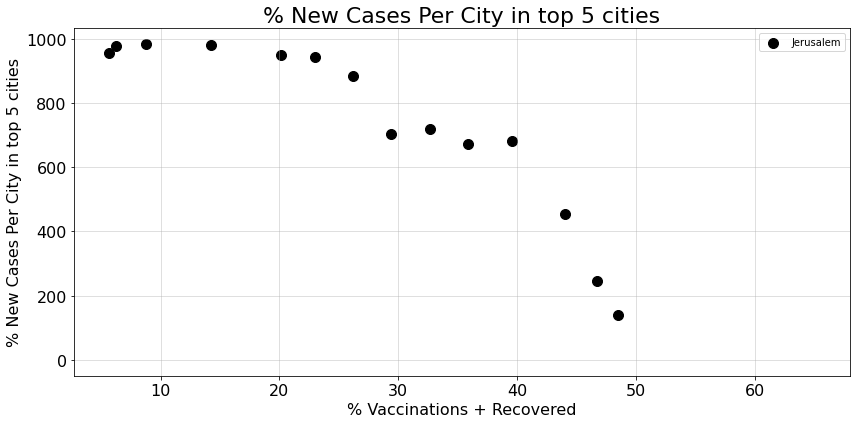

In [100]:
city ="ירושלים"
city_data = geo_stats_40[geo_stats_40['town'] == city]
c_english = city_data.town_english.iloc[0]
percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
percentage_new_cases_ashdod = city_data['new_cases_on_date']
plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c_english, color='k')
# city_data = geo_stats_40[geo_stats_40['town'] == 'חולון']
# percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
# percentage_new_cases_ashdod =  city_data['percentage_new_cases_on_date'] 
# plt.scatter(percentage_accumulated_ashdod, percentage_new_cases_ashdod, label=c, color='g')
plt.plot([40, 40], [0, 0.2], color='r', linestyle='--', alpha=0.5)
plt.plot([65, 65], [0, 0.2], color='b', linestyle='--', alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('% Vaccinations + Recovered')
plt.title(f'% New Cases Per City in top {num_cities} cities')
plt.ylabel(f'% New Cases Per City in top {num_cities} cities')

In [87]:
geo_stats_40['percentage_accumulated_immuned_normalized'] = geo_stats_40['percentage_accumulated_immuned']-geo_stats_40['percentage_accumulated_immuned_country']

/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
sorted_data = geo_stats_40.sort_values(ascending=False,by=['weeks_from', 'percentage_accumulated_immuned_normalized'])
cities = list(sorted_data[sorted_data.weeks_from == 53].iloc[[0, 1, 2, 3, 4, 5], :].town)
cities.append("ירושלים")

Text(0, 0.5, '% New Cases Per City in top 5 cities')

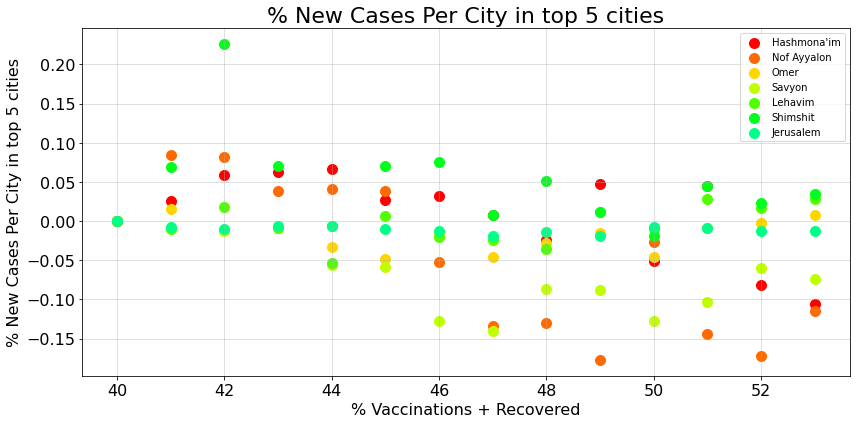

In [93]:
# cities =["ירושלים", "ביר הדאג'", "חשמונאים"]
colors_cities = get_cmap(15, 'hsv')
for i, c in enumerate(cities):
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    percentage_accumulated_ashdod = city_data['percentage_accumulated_vaccination_second_dose'] + city_data['percentage_accumulated_recoveries']
    percentage_new_cases_ashdod =  city_data['percentage_new_cases_on_date'] -city_data['percentage_new_cases_on_date_country']
    percentage_new_cases_ashdod = percentage_new_cases_ashdod - percentage_new_cases_ashdod.iloc[0]
    plt.scatter(city_data['weeks_from'], percentage_new_cases_ashdod, label=c_english, color=colors_cities[i], marker='o')
plt.grid()
plt.legend()
plt.xlabel('% Vaccinations + Recovered')
plt.title(f'% New Cases Per City in top {num_cities} cities')
plt.ylabel(f'% New Cases Per City in top {num_cities} cities')

In [109]:
city_data = geo_stats_40[geo_stats.town == 'ירושלים']

/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


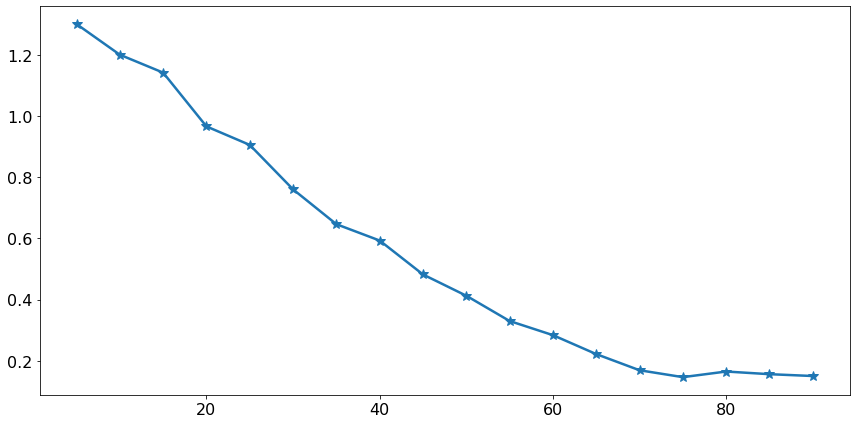

In [231]:
per_immu = {k: [] for k in np.arange(5, 105,5)}
for c in geo_stats_40.town.unique():
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
    diff_accu = diff_accu/(diff_accu[0]+1e-5)
    mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
    if diff_accu.max()<100:
        for a, p in zip(diff_accu, mean_per_immu):
            index = int(p//5)
            per_immu[(index+1) * 5].append(a)
# plt.plot(per_immu.keys(), mean_acc_diff, marker='*')


<BarContainer object of 20 artists>

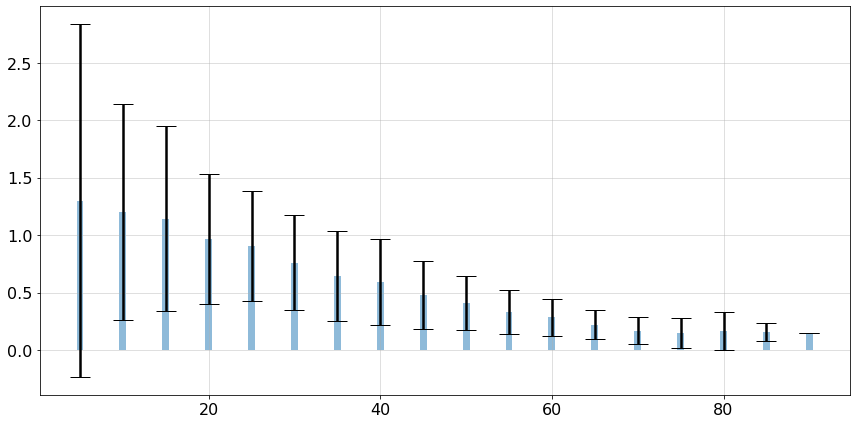

In [230]:
mean_acc_diff = [np.mean(l) for l in per_immu.values()]
std_acc_diff = [np.std(l) for l in per_immu.values()]
plt.grid()
plt.bar(per_immu.keys(), mean_acc_diff,
       yerr=std_acc_diff,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
# plt.yscale('symlog')

/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chanaross/opt/anaconda3/envs/torch_e

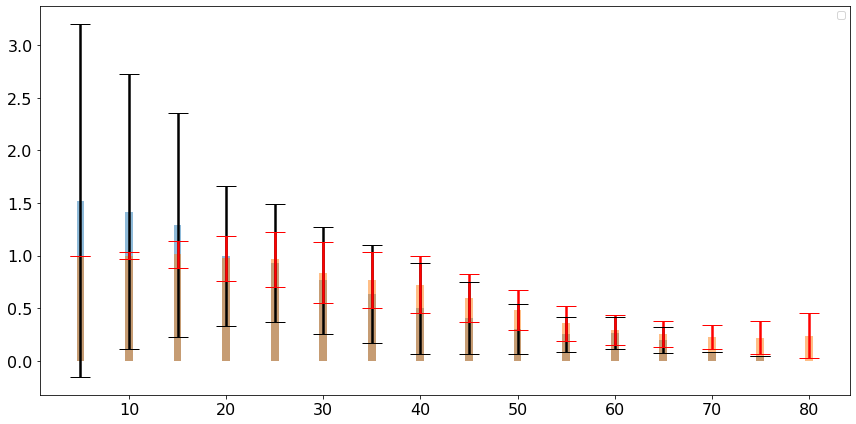

In [261]:
per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_young = geo_stats_40[geo_stats_40.median_age<np.mean(geo_stats_40.median_age)]
for c in geo_stats_40_young.town.unique():
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
    diff_accu = diff_accu/(diff_accu[0]+1e-5)
    mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
    if diff_accu.max()<100:
        for a, p in zip(diff_accu, mean_per_immu):
            index = int(p//5)
            per_immu_young[(index+1) * 5].append(a)
mean_acc_diff = [np.mean(l) for l in per_immu_young.values()]
std_acc_diff = [np.std(l) for l in per_immu_young.values()]
# plt.plot(per_immu.keys(), mean_acc_diff, marker='*', label='young')
# plt.grid()
plt.bar(per_immu.keys(), mean_acc_diff,
       yerr=std_acc_diff,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)

per_immu_old = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_old = geo_stats_40[geo_stats_40.median_age>np.mean(geo_stats_40.median_age)]
for c in geo_stats_40_old.town.unique():
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    diff_accu = moving_average(np.diff(city_data['accumulated_cases']), 4)
    diff_accu = diff_accu/(diff_accu[0]+1e-5)
    mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
    if diff_accu.max()<100:
        for a, p in zip(diff_accu, mean_per_immu):
            index = int(p//5)
            per_immu_old[(index+1) * 5].append(a)
mean_acc_diff = [np.mean(l) for l in per_immu_old.values()]
std_acc_diff = [np.std(l) for l in per_immu_old.values()]
# plt.plot(per_immu.keys(), mean_acc_diff, marker='*', label='old')
plt.grid()
# plt.figure()
plt.bar(per_immu.keys(), mean_acc_diff,
       yerr=std_acc_diff,
       align='center',
       alpha=0.5,
       ecolor='red',
       capsize=10)
# plt.yscale('symlog')
plt.grid()
plt.legend()

/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chanaross/opt/anaconda3/envs/torch_e

Text(0.5, 0, 'percentage immuned')

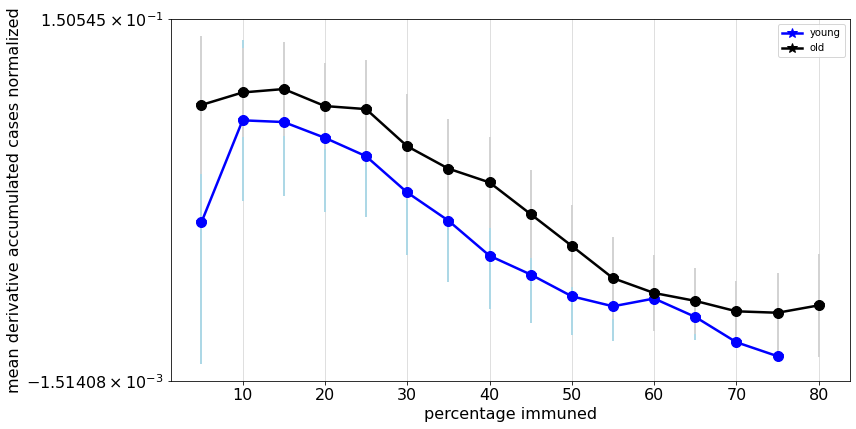

In [296]:
per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_young = geo_stats_40[geo_stats_40.median_age<np.mean(geo_stats_40.median_age)]
for c in geo_stats_40_young.town.unique():
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    del_acc = (np.max(city_data['accumulated_cases']) - np.min(city_data['accumulated_cases']))
    accu = (city_data['accumulated_cases'] - np.min(city_data['accumulated_cases']))/del_acc   
    diff_accu = moving_average(np.diff(accu), 4)
#     diff_accu = diff_accu/(diff_accu[0]+1e-5)
    mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
    if diff_accu.max()<100:
        for a, p in zip(diff_accu, mean_per_immu):
            index = int(p//5)
            per_immu_young[(index+1) * 5].append(a)
mean_acc_diff = [np.mean(l) for l in per_immu_young.values()]
std_acc_diff = [np.std(l) for l in per_immu_young.values()]
plt.grid()
plt.errorbar(per_immu.keys(), mean_acc_diff,
       yerr=std_acc_diff, fmt='o', color='b',
             ecolor='lightblue', elinewidth=2, capsize=0)
plt.plot(per_immu.keys(), mean_acc_diff, marker='*', label='young', color='b')

# plt.bar(per_immu.keys(), mean_acc_diff,
#        yerr=std_acc_diff,
#        align='center',
#        alpha=0.5,
#        ecolor='black',
#        capsize=10)

per_immu_old = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_old = geo_stats_40[geo_stats_40.median_age>np.mean(geo_stats_40.median_age)]
for c in geo_stats_40_old.town.unique():
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    del_acc = (np.max(city_data['accumulated_cases']) - np.min(city_data['accumulated_cases']))
    accu = (city_data['accumulated_cases'] - np.min(city_data['accumulated_cases']))/del_acc
    diff_accu = moving_average(np.diff(accu), 4)
#     diff_accu = diff_accu/(diff_accu[0]+1e-5)
    mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
    if diff_accu.max()<100:
        for a, p in zip(diff_accu, mean_per_immu):
            index = int(p//5)
            per_immu_old[(index+1) * 5].append(a)
mean_acc_diff = [np.mean(l) for l in per_immu_old.values()]
std_acc_diff = [np.std(l) for l in per_immu_old.values()]
plt.grid()
plt.errorbar(per_immu.keys(), mean_acc_diff,
       yerr=std_acc_diff, fmt='o', color='black',
             ecolor='lightgray', elinewidth=2, capsize=0)
plt.plot(per_immu.keys(), mean_acc_diff, marker='*', label='old', color='k')

#        align='center',
#        alpha=0.5,
#        ecolor='red',
#        capsize=10, color='r')
plt.yscale('symlog')
plt.grid()
plt.legend()
plt.ylabel('mean derivative accumulated cases normalized')
plt.xlabel('percentage immuned')

/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/chanaross/opt/anaconda3/envs/torch_env/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/chanaross/opt/anaconda3/envs/torch_e

Text(0.5, 0, 'percentage immuned')

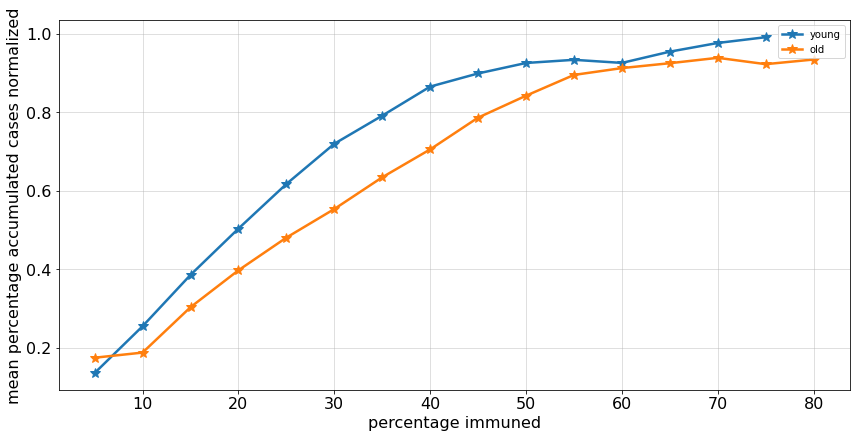

In [283]:
per_immu_young = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_young = geo_stats_40[geo_stats_40.median_age<np.mean(geo_stats_40.median_age)]
for c in geo_stats_40_young.town.unique():
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    del_acc = (np.max(city_data['percentage_accumulated_cases']) - np.min(city_data['percentage_accumulated_cases']))
    accu = (city_data['percentage_accumulated_cases'] - np.min(city_data['percentage_accumulated_cases']))/del_acc   
    diff_accu = moving_average((accu), 4)
#     diff_accu = diff_accu/(diff_accu[0]+1e-5)
    mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
    if diff_accu.max()<100:
        for a, p in zip(diff_accu, mean_per_immu):
            index = int(p//5)
            per_immu_young[(index+1) * 5].append(a)
mean_acc_diff = [np.mean(l) for l in per_immu_young.values()]
std_acc_diff = [np.std(l) for l in per_immu_young.values()]
plt.plot(per_immu.keys(), mean_acc_diff, marker='*', label='young')
# plt.grid()
# plt.bar(per_immu.keys(), mean_acc_diff,
#        yerr=std_acc_diff,
#        align='center',
#        alpha=0.5,
#        ecolor='black',
#        capsize=10)

per_immu_old = {k: [] for k in np.arange(5, 105,5)}
geo_stats_40_old = geo_stats_40[geo_stats_40.median_age>np.mean(geo_stats_40.median_age)]
for c in geo_stats_40_old.town.unique():
    city_data = geo_stats_40[geo_stats_40['town'] == c]
    c_english = city_data.town_english.iloc[0]
    del_acc = (np.max(city_data['percentage_accumulated_cases']) - np.min(city_data['percentage_accumulated_cases']))
    accu = (city_data['percentage_accumulated_cases'] - np.min(city_data['percentage_accumulated_cases']))/del_acc
    diff_accu = moving_average((accu), 4)
#     diff_accu = diff_accu/(diff_accu[0]+1e-5)
    mean_per_immu =  moving_average(city_data['percentage_accumulated_immuned'], 4)[:-1]
    if diff_accu.max()<100:
        for a, p in zip(diff_accu, mean_per_immu):
            index = int(p//5)
            per_immu_old[(index+1) * 5].append(a)
mean_acc_diff = [np.mean(l) for l in per_immu_old.values()]
std_acc_diff = [np.std(l) for l in per_immu_old.values()]
plt.plot(per_immu.keys(), mean_acc_diff, marker='*', label='old')
# plt.grid()
# plt.bar(per_immu.keys(), mean_acc_diff,
#        yerr=std_acc_diff,
#        align='center',
#        alpha=0.5,
#        ecolor='red',
#        capsize=10, color='r')
# plt.yscale('symlog')
plt.grid()
plt.legend()
plt.ylabel('mean percentage accumulated cases normalized')
plt.xlabel('percentage immuned')